In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
import py_rdl
import RA

# Cremer Pople Puckering Parameter

In [84]:
# Five
five = pd.read_csv("five.csv")

In [168]:
mol = Chem.MolFromSmiles("C1CCCCC12CCCCCC2")

In [129]:
RA.GetRingElement(mol, [5,4,3,2,1])

[(5, 6), (4, 6), (3, 6), (2, 6), (1, 6)]

In [150]:
ringatom = Chem.MolFromSmarts("[r]")

In [176]:
def GetRingAtomType(mol, ringidx):
    """
    Input:
    
    mol: rdMol
    
    ringidx: list
    
    Return:
    
    outcome: list
    
    """
    ringatom = Chem.MolFromSmarts("[R]")
    monocyclicatom = Chem.MolFromSmarts("[R1]")
    bicyclicatom = Chem.MolFromSmarts("[R2]")
    ringatom_match = [a for x in mol.GetSubstructMatches(ringatom) for a in x]
    monocyclic_match = [a for x in mol.GetSubstructMatches(monocyclicatom) for a in x]
    bicyclic_match = [a for x in mol.GetSubstructMatches(bicyclicatom) for a in x]
    outcome = []
    for i in ringidx:
        if (i in ringatom_match) and (i in monocyclic_match):
            outcome.append("M")
        elif (i in ringatom_match) and (i in bicyclic_match):
            outcome.append("B")
        elif (i in ringatom_match) and (i not in monocyclic_match) and (i not in bicyclic_match):
            outcome.append("P")
        else:
            outcome.append("NA")
    return outcome

In [181]:
list(range(2,2))

[]

In [180]:
[item[1] for item in RA.GetRingBonds(mol, range(6))]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [177]:
GetRingAtomType(mol, list(range(8)))

['M', 'M', 'M', 'M', 'M', 'B', 'M', 'M']

In [159]:
mol.GetSubstructMatches(ringatom)

((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,))

In [160]:
mol.GetSubstructMatches(monocyclicatom)

((0,), (1,), (2,), (3,), (4,), (6,), (7,), (8,), (9,), (10,), (11,))

In [165]:
mol.GetSubstructMatches(bicyclicatom)

((5,),)

In [87]:
aromatic = []
aliphatic = []
for row in five.iterrows():
    check = [x==1.5 for x in eval(row[1][2])]
    if all(check):
        aromatic.append(row[1])
    else:
        aliphatic.append(row[1])

In [113]:
s1 = []
s2 = []
s3 = []
for item in aliphatic:
    check = sum(eval(item[2]))
    if check==5.5:
        tmp = eval(item[1])
        s1.append((tmp[0][0],tmp[1][0]))
    elif check==6:
        tmp = eval(item[1])
        s2.append((tmp[0][0],tmp[1][0]))
    elif check==5:
        tmp = eval(item[1])
        s3.append((tmp[0][0],tmp[1][0]))

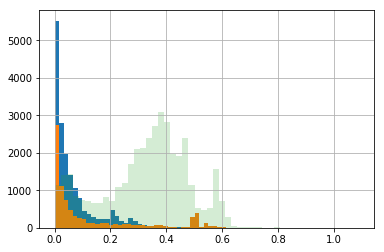

In [116]:
pd.DataFrame(s1)[0].hist(bins=50)
pd.DataFrame(s2)[0].hist(bins=50)
pd.DataFrame(s3)[0].hist(bins=50,alpha=.2)

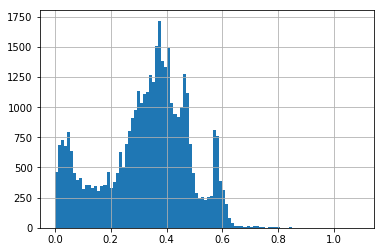

In [122]:
#pd.DataFrame(s1)[1].hist(bins=50)
#pd.DataFrame(s2)[1].hist(bins=50)
pd.DataFrame(s3)[0].hist(bins=100)

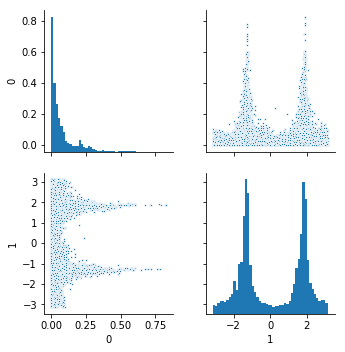

In [101]:
sns.pairplot(pd.DataFrame(s1),plot_kws=dict(s=5), diag_kws=dict(bins=50))

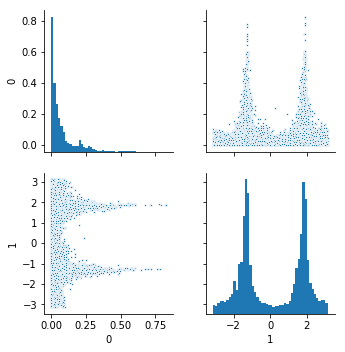

In [97]:
sns.pairplot(pd.DataFrame(single),plot_kws=dict(s=5), diag_kws=dict(bins=50))

In [94]:
single

[(0.2848034915079273, -2.292798693308324),
 (0.33553064266867805, -1.8217251036889979),
 (0.27776909439803155, 1.8458247392098635),
 (0.37571555559391645, 0.11763257807879782),
 (0.1174073027109944, 1.3270958959529875),
 (0.07458436708832693, -2.0775128595232095),
 (0.5938530386214393, -2.53960504032057),
 (0.5115211923585276, -2.381198437802945),
 (0.3783492850366892, 1.4177473646159897),
 (0.06881102675687506, 1.942985472342124),
 (0.3002756847771072, -1.459293226648983),
 (0.2641582585320819, -0.6629209309091586),
 (0.365686280496495, -1.4500313166622876),
 (0.37635153479686656, 1.7359058796004823),
 (0.37663356587784147, -1.4035115854298885),
 (0.2646142001413494, 1.2789332469959565),
 (0.4503804622833438, -1.817537192653416),
 (0.3776184266989478, -1.0038994231507743),
 (0.47561121419019936, 0.7926304172378709),
 (0.15805767585074124, 1.4243156238195593),
 (0.3005059646122033, 0.8668840749811332),
 (0.5278201301331735, 0.4310851023023268),
 (0.08818013426540926, 1.894324380426187)

# Substituents Orientation

In [15]:
fluorine = pd.read_csv("data/halogen_f.csv")
chlorine = pd.read_csv("data/halogen_cl.csv")
bromine = pd.read_csv("data/halogen_br.csv")
iodine = pd.read_csv("data/halogen_i.csv")
amine0 = pd.read_csv("data/amine_0.csv")
amine1 = pd.read_csv("data/amine_1.csv")
amine2 = pd.read_csv("data/amine_2.csv")
alkoxy = pd.read_csv("data/alkoxy.csv")
hydroxyl = pd.read_csv("data/hydroxyl.csv")
methyl = pd.read_csv("data/methyl.csv")
ketone = pd.read_csv("data/ketone.csv")
carboxylicacid_0 = pd.read_csv("data/carboxylicacid_0.csv")
carboxylicacid_1 = pd.read_csv("data/carboxylicacid_1.csv")
carboxylicacid_2 = pd.read_csv("data/carboxylicacid_2.csv")
carbonyl = pd.read_csv("data/carbonyl.csv")

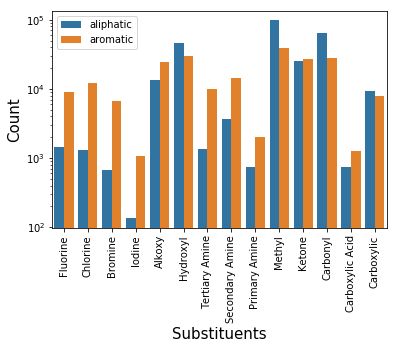

In [31]:
# Substituents
aliphatic = [len(aliphatic_fluorine),len(aliphatic_chlorine),len(aliphatic_bromine), len(aliphatic_iodine), 
             len(aliphatic_alkoxy), len(aliphatic_hydroxyl), len(aliphatic_amine0),len(aliphatic_amine1)
             ,len(aliphatic_amine2), len(aliphatic_methyl), len(aliphatic_ketone), len(aliphatic_carbonyl), len(aliphatic_carboxylicacid0),
            len(aliphatic_carboxylicacid1)]
aromatic = [len(aromatic_fluorine),len(aromatic_chlorine),len(aromatic_bromine), len(aromatic_iodine), 
           len(aromatic_alkoxy), len(aromatic_hydroxyl), len(aromatic_amine0), len(aromatic_amine1),
            len(aromatic_amine2), len(aromatic_methyl), len(aromatic_ketone), len(aromatic_carbonyl), len(aromatic_carboxylicacid0),
           len(aromatic_carboxylicacid1)]
types = ["aliphatic"]*len(aliphatic) + ["aromatic"]*len(aromatic)
name = ["Fluorine","Chlorine","Bromine","Iodine","Alkoxy","Hydroxyl","Tertiary Amine","Secondary Amine","Primary Amine", 
        "Methyl", "Ketone", "Carbonyl","Carboxylic Acid", "Carboxylic"]

dataframe = pd.DataFrame({"Types":types,"Count":aliphatic+aromatic, "Name":name*2})

sns.barplot(x="Name",y="Count", data=dataframe, hue="Types")
plt.yscale("log")
plt.xticks(range(len(name)), name, rotation='vertical')
plt.xlabel("Substituents",size=15)
plt.ylabel("Count",size=15)
plt.legend()
plt.show()

In [27]:
aromatic_fluorine = fluorine[fluorine["aromatic"]==True]
aliphatic_fluorine = fluorine[fluorine["aromatic"]==False]

aromatic_chlorine = chlorine[chlorine["aromatic"]==True]
aliphatic_chlorine = chlorine[chlorine["aromatic"]==False]

aromatic_bromine = bromine[bromine["aromatic"]==True]
aliphatic_bromine = bromine[bromine["aromatic"]==False]

aromatic_iodine = iodine[iodine["aromatic"]==True]
aliphatic_iodine = iodine[iodine["aromatic"]==False]

aromatic_methyl = methyl[methyl["aromatic"]==True]
aliphatic_methyl = methyl[methyl["aromatic"]==False]

aromatic_alkoxy = alkoxy[alkoxy["aromatic"]==True]
aliphatic_alkoxy = alkoxy[alkoxy["aromatic"]==False]

aromatic_hydroxyl = hydroxyl[hydroxyl["aromatic"]==True]
aliphatic_hydroxyl = hydroxyl[hydroxyl["aromatic"]==False]

aromatic_amine0 = amine0[amine0["aromatic"]==True]
aliphatic_amine0 = amine0[amine0["aromatic"]==False]

aromatic_amine1 = amine1[amine1["aromatic"]==True]
aliphatic_amine1 = amine1[amine1["aromatic"]==False]

aromatic_amine2 = amine2[amine2["aromatic"]==True]
aliphatic_amine2 = amine2[amine2["aromatic"]==False]

aromatic_ketone = ketone[ketone["aromatic"]==True]
aliphatic_ketone = ketone[ketone["aromatic"]==False]

aromatic_carbonyl = carbonyl[carbonyl["aromatic"]==True]
aliphatic_carbonyl = carbonyl[carbonyl["aromatic"]==False]

aromatic_carboxylicacid0 = carboxylicacid_0[carboxylicacid_0["aromatic"]==True]
aliphatic_carboxylicacid0 = carboxylicacid_0[carboxylicacid_0["aromatic"]==False]

aromatic_carboxylicacid1 = carboxylicacid_1[carboxylicacid_1["aromatic"]==True]
aliphatic_carboxylicacid1 = carboxylicacid_1[carboxylicacid_1["aromatic"]==False]

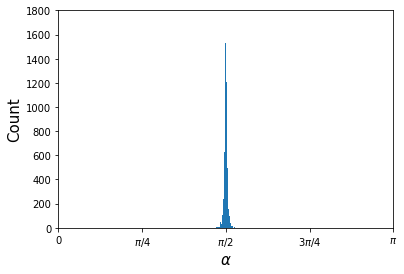

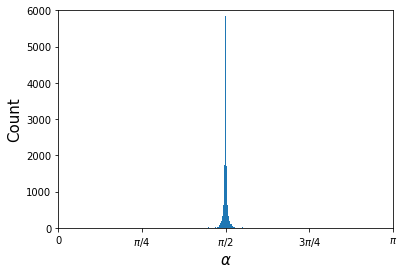

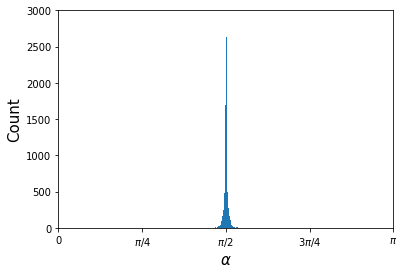

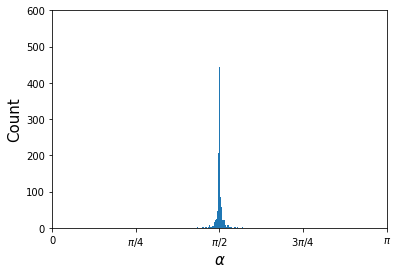

In [129]:
plt.hist(aromatic_fluorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,1800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_flurine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_chlorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,6000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_chlorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_bromine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,3000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_bromine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_iodine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_iodine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

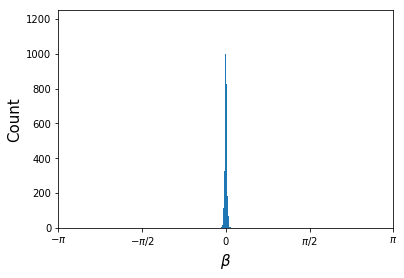

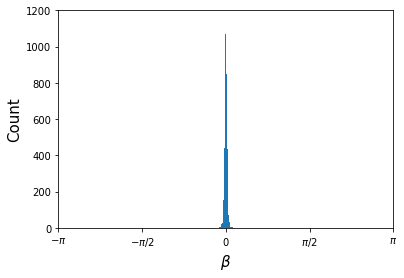

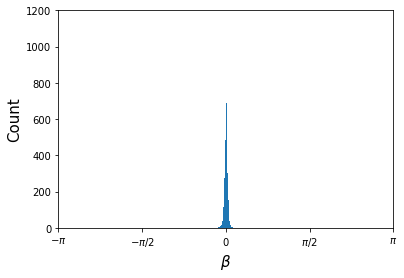

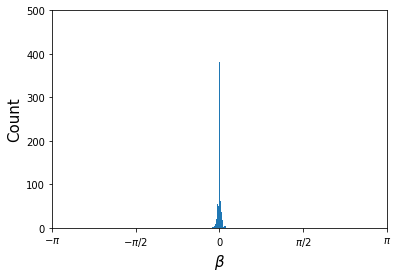

In [131]:
plt.hist(aromatic_fluorine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1250)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_fluorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_chlorine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_chlorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_bromine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_bromine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_iodine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_iodine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

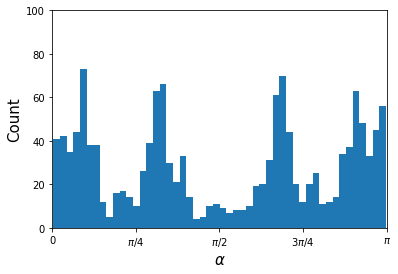

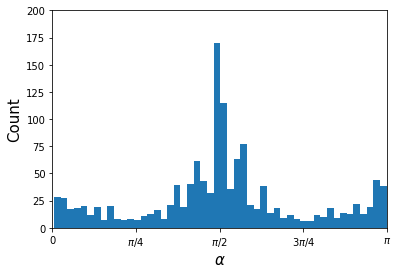

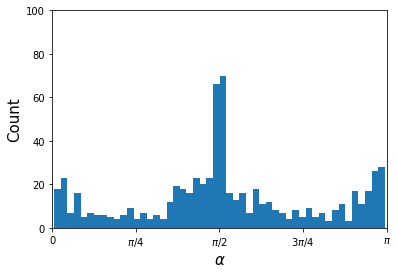

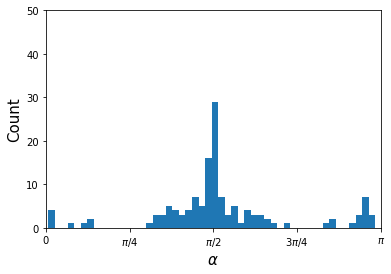

In [135]:
plt.hist(aliphatic_fluorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_fluorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_chlorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,200)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_chlorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_bromine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_bromine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_iodine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,50)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_iodine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

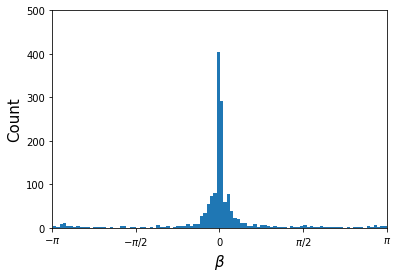

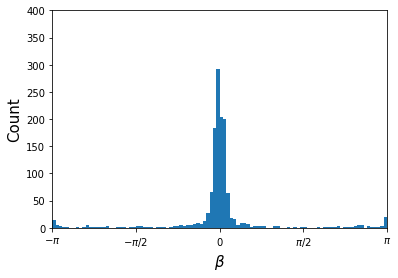

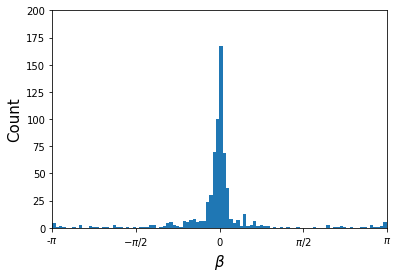

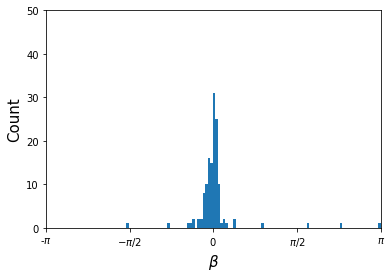

In [132]:
plt.hist(aliphatic_fluorine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_fluorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_chlorine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,400)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_chlorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_bromine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"-$\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_bromine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_iodine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"-$\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,50)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_iodine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Methyl

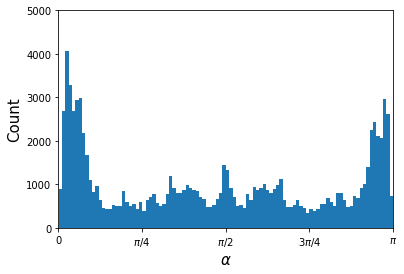

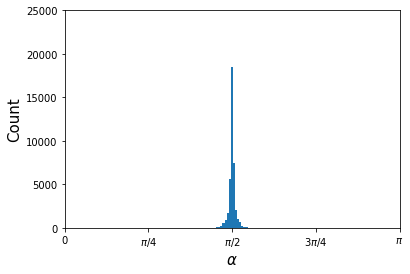

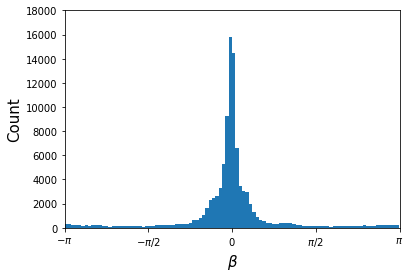

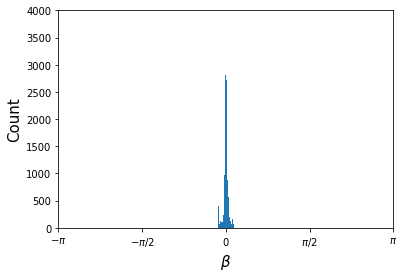

In [44]:
plt.hist(aliphatic_methyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,5000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_methyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_methyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,25000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_methyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_methyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,18000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_methyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_methyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,4000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_methyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Alkoxy and Hydroxyl

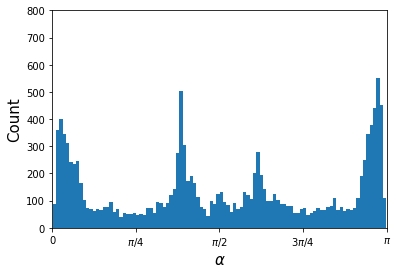

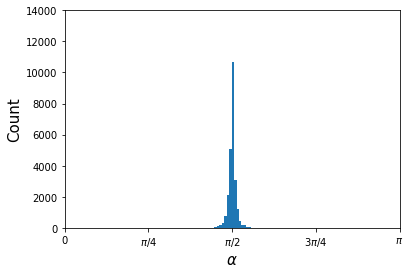

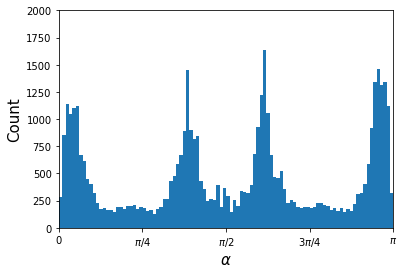

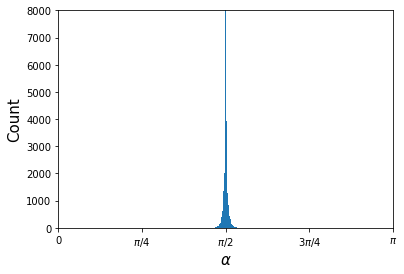

In [47]:
plt.hist(aliphatic_alkoxy["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_alkoxy_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_alkoxy["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,14000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_alkoxy_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_hydroxyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,2000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_hydroxyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_hydroxyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,8000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_hydroxyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()


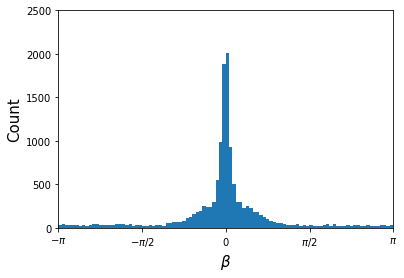

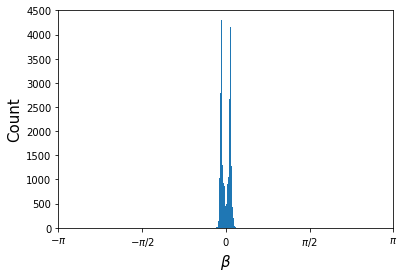

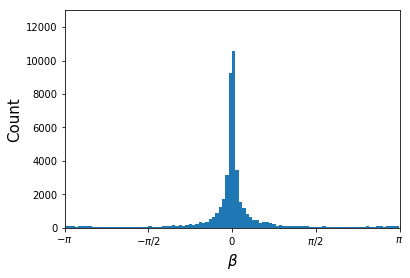

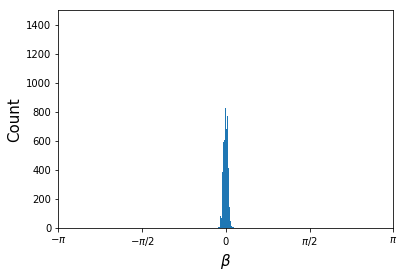

In [48]:
plt.hist(aliphatic_alkoxy["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,2500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_alkoxy_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_alkoxy["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,4500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_alkoxy_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_hydroxyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,13000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_hydroxyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_hydroxyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_hydroxyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Amine

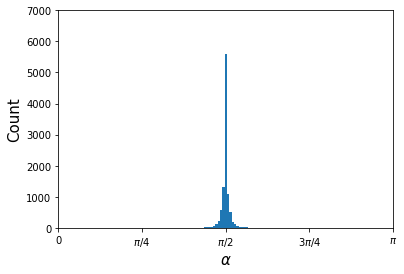

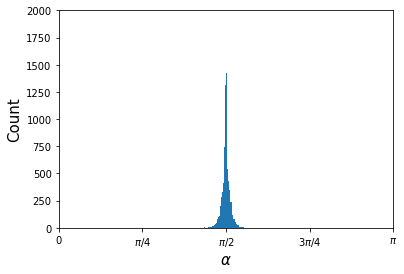

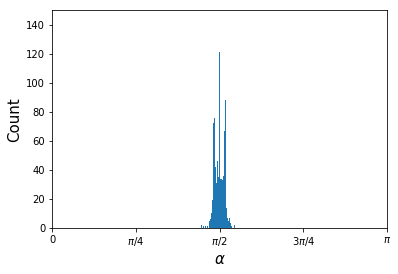

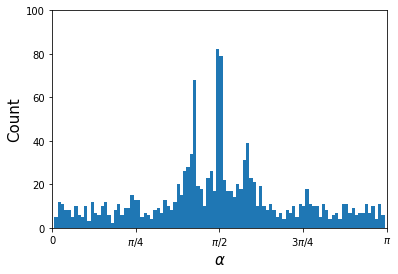

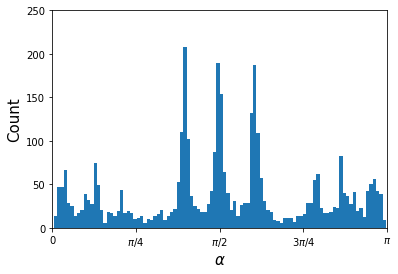

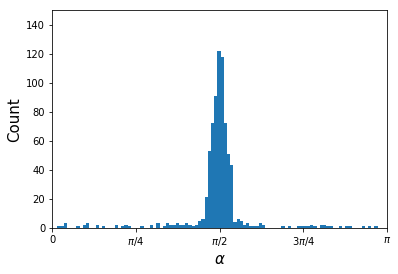

In [40]:
## Aromatic
plt.hist(aromatic_amine0["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,7000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine0_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine1["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,2000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine1_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine2["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,150)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine2_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()


plt.hist(aliphatic_amine0["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine0_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine1["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,250)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine1_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine2["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,150)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine2_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()



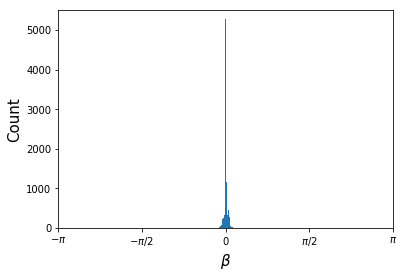

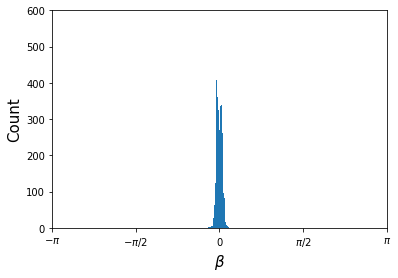

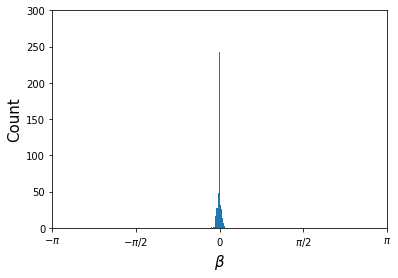

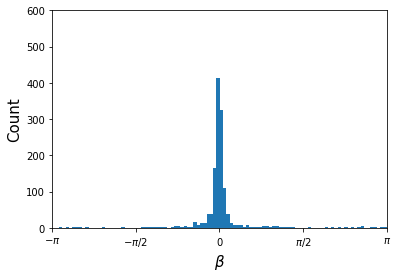

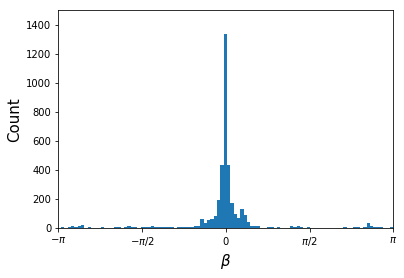

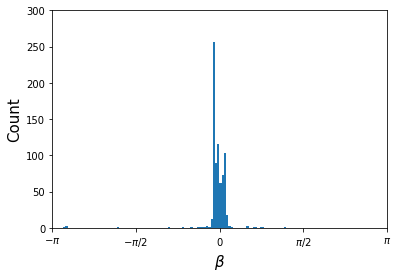

In [41]:
## Aromatic
plt.hist(aromatic_amine0["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,5500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine0_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine1["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine1_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine2["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,300)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine2_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

## Aliphatic
plt.hist(aliphatic_amine0["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine0_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine1["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine1_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine2["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,300)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine2_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Ketone

In [ ]:
plt.hist(aliphatic_ketone["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_ketone_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_ketone["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,9000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_ketone_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

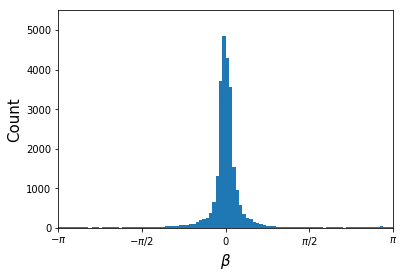

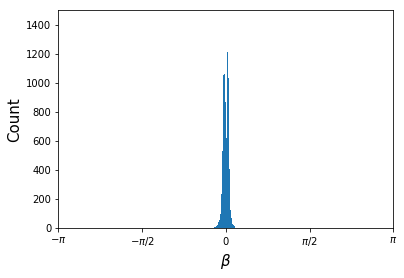

In [51]:
plt.hist(aliphatic_ketone["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,5500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_ketone_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_ketone["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_ketone_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Carbonyl

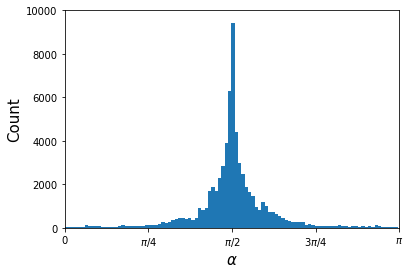

In [54]:
plt.hist(aliphatic_carbonyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,10000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_carbonyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

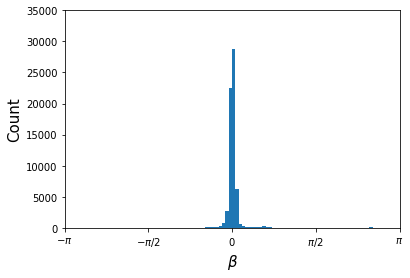

In [61]:
plt.hist(aliphatic_carbonyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,35000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
#plt.savefig("aliphatic_carbonyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()


In [3]:
alkoxy = Chem.SDMolSupplier("molecule/f.sdf")
alkoxy_smarts = "[R][F&!R]"
c1 = []
for idx, mol in enumerate(alkoxy):
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if (len(list(rc.nodes))<20) and (len(list(rc.nodes))>4):
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ox = RA.GetSubstituent(mol, list(rc.nodes), alkoxy_smarts)
                if any(ox):
                    for i in ox:
                        ccoord = RA.Translate(coord)
                        cptmp = RA.GetRingPuckerCoords(ccoord)
                        ohpos = RA.GetRingSubstituentPosition(mol, ringloop, i)
                        b = RA.GetRingBonds(mol, ringloop)
                        c1.append((idx,cptmp,ohpos,b))


In [62]:
RA.GetRingBonds(mol)

NameError: name 'mol' is not defined

In [63]:
mol = Chem.MolFromSmiles("c1ccccc1")

In [64]:
RA.GetRingBonds(mol,list(range(6)))

[((0, 1), 1.5),
 ((1, 2), 1.5),
 ((2, 3), 1.5),
 ((3, 4), 1.5),
 ((4, 5), 1.5),
 ((0, 5), 1.5)]